# Improve Efficiency and Scalibity

With advancements in biotechnology, the resolution of spatial transcriptomics (ST) has evolved from the spot level to single-cell and even subcellular levels, with a single slice containing from hundreds to 500,000 data points. This scale of data poses a significant challenge for computational tools. In this tutorial, we will introduce several methods that can significantly accelerate runtime and increase scalability for Spateo alignment. Specifically, Spateo incorporates GPU hardware acceleration, sparse computation, stochastic variational inference (SVI), inducing variables, and downsampling techniques. We believe these methods will enable Spateo to efficiently handle various types of data.

In [41]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running this notebook on: ", device)

import spateo as st
print("Last run with spateo version:", st.__version__)

# Other imports
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import numpy as np
import time

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

Running this notebook on:  cuda
Last run with spateo version: 1.1.0.dev30+084c763.dirty
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## About the Data

In this tutorial, we will use several ST data with different resolution/cell number based on various techniques. You can download the processed data from the links below. Once downloaded, ensure that you place the data in the appropriate directory.

- [SCC (squamous cell carcinoma) patient 9 slice #1](https://drive.google.com/file/d/1fPAxQl56-e8dP23M8RF9s2VZT884C2Rw/view?usp=drive_link)
- [SCC (squamous cell carcinoma) patient 9 slice #2](https://drive.google.com/file/d/1fTax8motkn5nDEG3Iluu0RteXkKcobCI/view?usp=drive_link)
- [Mouse embryo E9.5 (Stereo-Seq) slice #14](https://drive.google.com/file/d/1eqGjZ2vc11SQ2cuEzFTjA2eu7WpHy5Yd/view?usp=drive_link)
- [Mouse embryo E9.5 (Stereo-Seq) slice #15](https://drive.google.com/file/d/1eyoZcYfZY-VlWIJnnHgeE0zdSTKQTWLC/view?usp=drive_link)
- [Adult mouse brain (STARMap Plus) 20% overlap slice #1](https://drive.google.com/file/d/1fEPar7weOVzTShIXCNiI3gNHoMGpBkfi/view?usp=drive_link)
- [Adult mouse brain (STARMap Plus) 20% overlap slice #2](https://drive.google.com/file/d/1fLiAFB8vKkbX4pFpZb-ISu2x7tk2ez_0/view?usp=drive_link)
- [Drosophila (Stereo-Seq) E7-9h slice #16](https://drive.google.com/file/d/1eliFZnkVureDnvG0Gdz0ejxsmR2OD_Xh/view?usp=drive_link)
- [Drosophila (Stereo-Seq) E7-9h slice #17](https://drive.google.com/file/d/1eksLSPKusw2H-b3y5ad-e4e69g1sLgUT/view?usp=drive_link)
- [Adult mouse hemibrain (MERFISH) slice #78](https://drive.google.com/file/d/1efKb2GJU8pUAYSA4ueB375aj8RfacyZJ/view?usp=drive_link)
- [Adult mouse hemibrain (MERFISH) slice #79](https://drive.google.com/file/d/1ef4eQHA3ywaIBUCkZL2ysyRDkjWa1qIS/view?usp=drive_link)
- [Adult mouse brain cell atlas (MERFISH) slice #30](https://drive.google.com/file/d/1egO1ii_f_JT8EC0joFd9HWPPPvx5rJlR/view?usp=drive_link)
- [Adult mouse brain cell atlas (MERFISH) slice #31](https://drive.google.com/file/d/1ejrSR7dezjbbpDFrhUPOs-Mx_fzaWK9E/view?usp=drive_link)

## GPU hardware acceleration

If your device or server supports CUDA, you can leverage GPU parallel computing to significantly accelerate computational efficiency. By passing `device='cuda'` or `device='your GPU ID'` to `st.align.morpho_align`, you can enable GPU-based computation.

<div class="alert alert-warning">
<strong>Warning:</strong>
    
Before enabling GPU computation, make sure that the CUDA version of PyTorch is correctly installed. You can verify if the GPU is set up correctly by running:
```
import torch
print(torch.cuda.is_available())
```

Additionally, due to the limitations of GPU memory, running large-scale data may lead to GPU memory overflow issues. If this happens, refer to the sections on sparse computation and downsampling for help.
    
</div>

### SCC data

We’ll start by testing on the SCC dataset (approximately 1,000 spots) to observe how GPU accelerates the alignment process.

In [3]:
slice1 = st.read('./data/SCC_patient_9_slice_1.h5ad')
slice2 = st.read('./data/SCC_patient_9_slice_2.h5ad')

slice1, slice2

(AnnData object with n_obs × n_vars = 1035 × 10176
     obs: 'original_clusters', 'n_genes'
     var: 'n_cells'
     obsm: 'spatial',
 AnnData object with n_obs × n_vars = 828 × 8399
     obs: 'original_clusters', 'n_genes'
     var: 'n_cells'
     obsm: 'spatial')

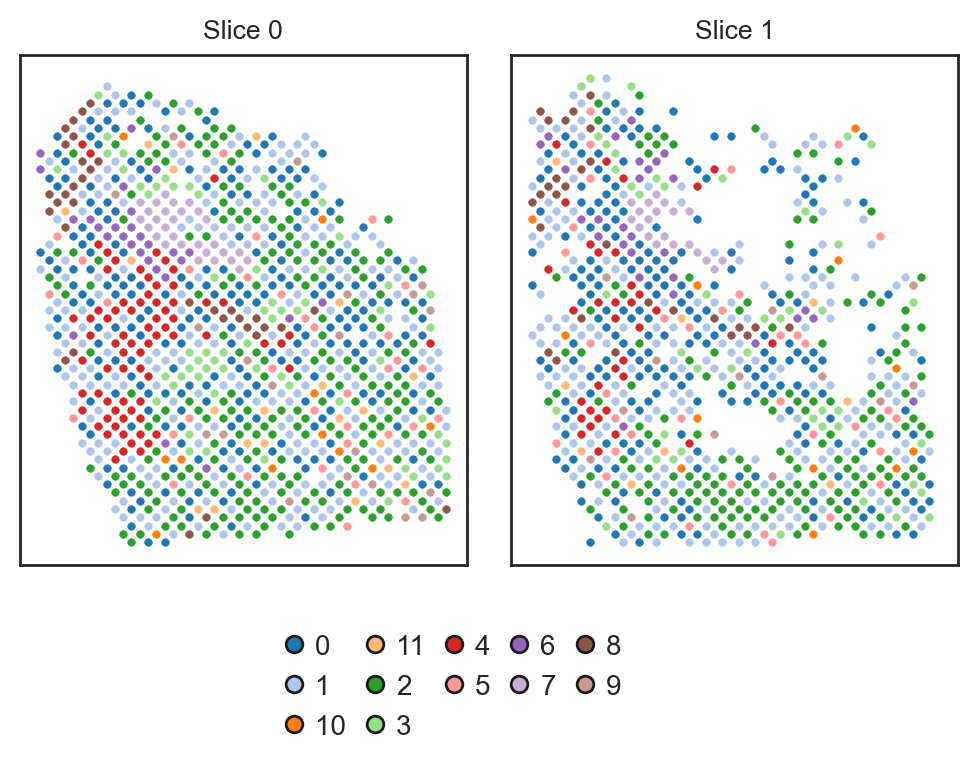

In [4]:
spatial_key = 'spatial'
cluster_key = 'original_clusters'
st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=False,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
)

In [6]:
key_added = 'align_spatial'

# run on cuda
t_start = time.time()
aligned_slices, _ = st.align.morpho_align(models=[slice1, slice2],spatial_key=spatial_key,key_added=key_added,device=device,verbose=False,)
t_cuda = time.time() - t_start

# run on cpu
t_start = time.time()
aligned_slices, _ = st.align.morpho_align(models=[slice1, slice2],spatial_key=spatial_key,key_added=key_added,device='cpu',verbose=False,)
t_cpu= time.time() - t_start

print(f"Alignment on GPU is faster {t_cpu / t_cuda} times than CPU on SCC dataset.")

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [1.2399s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [7.4927s]
Alignment on GPU is faster 5.829919246413159 times than CPU on SCC dataset.


Let's check the alignment results.

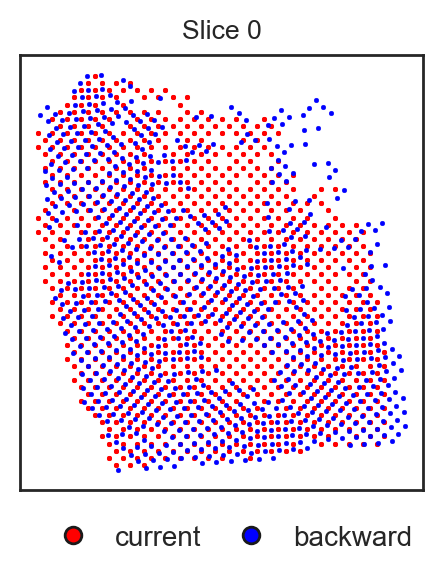

In [7]:
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, height=3, overlay_type='backward',  legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0),'borderaxespad': -2, 'frameon': False})

### Mouse embryo E9.5 data

We next test the mouse embryo dataset (approximately 18,000 spots) to see how GPU accelerates the alignment process.

In [7]:
slice1 = st.read('./data/E95_cellbin_14.h5ad')
slice2 = st.read('./data/E95_cellbin_15.h5ad')

slice1, slice2

(AnnData object with n_obs × n_vars = 18520 × 20517
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'cellbin_SpatialDomain', 'n_genes'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: '__type', 'hvg', 'log1p', 'louvain', 'neighbors', 'pca', 'pearson_residuals_normalization', 'spatial'
     obsm: 'X_pca', 'X_spatial', 'spatial'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 18322 × 20195
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'cellbin_SpatialDomain', 'n_genes'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: '__type', 'hvg', 'log1p', 'louvain', 'neighbors', 'pca', 'pearson_residuals_normalization', 'spatial'
     obsm: 'X_pca', 'X_spatial', 'spatial'
     layers: 'counts')

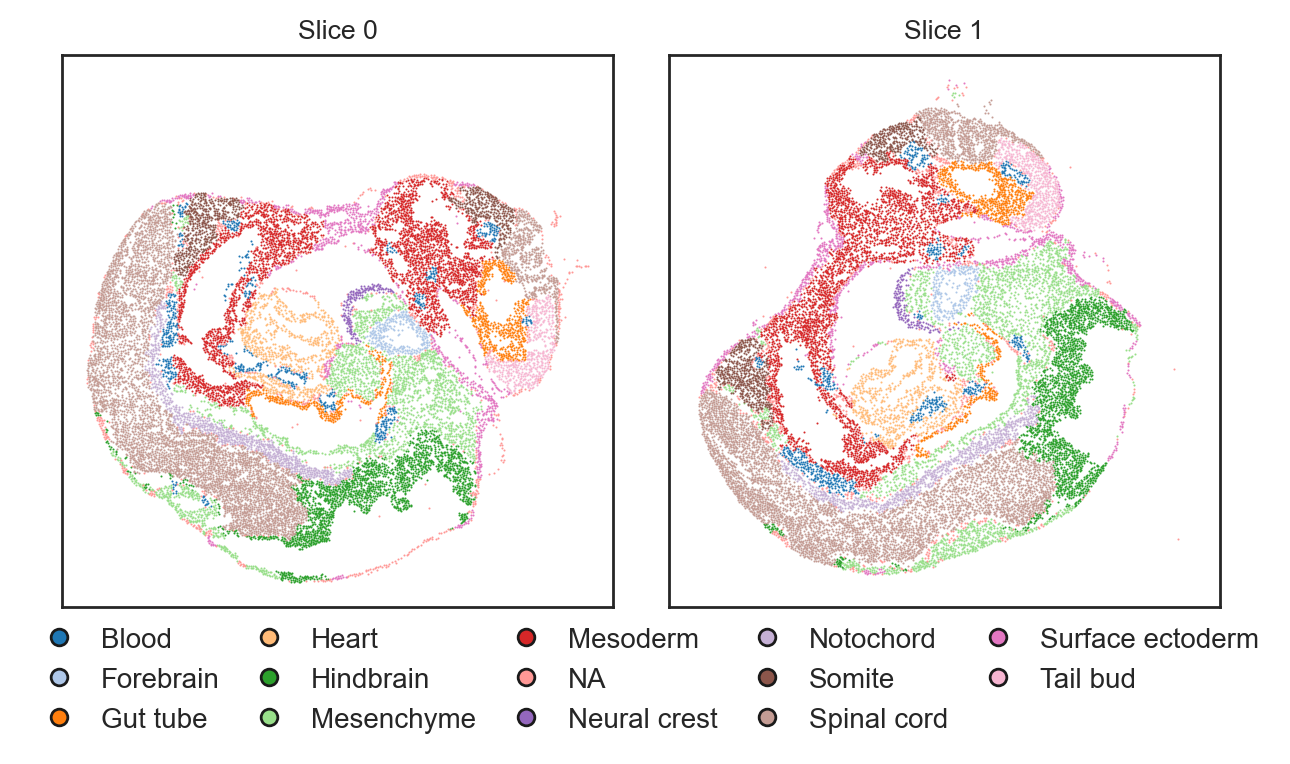

In [8]:
spatial_key = 'spatial'
cluster_key = 'cellbin_SpatialDomain'
st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=True,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
)

In [9]:
key_added = 'align_spatial'

# run on cuda
t_start = time.time()
aligned_slices, _ = st.align.morpho_align(models=[slice1, slice2],spatial_key=spatial_key,key_added=key_added,device=device,verbose=False,)
t_cuda = time.time() - t_start

# run on cpu
t_start = time.time()
aligned_slices, _ = st.align.morpho_align(models=[slice1, slice2],spatial_key=spatial_key,key_added=key_added,device='cpu',verbose=False,)
t_cpu= time.time() - t_start

print(f"Alignment on GPU is faster {t_cpu / t_cuda} times than CPU on Mouse embryo E9.5 dataset.")

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [5.0260s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [472.8618s]
Alignment on GPU is faster 90.2457246643551 times than CPU on Mouse embryo E9.5 dataset.


Let's check the alignment results.

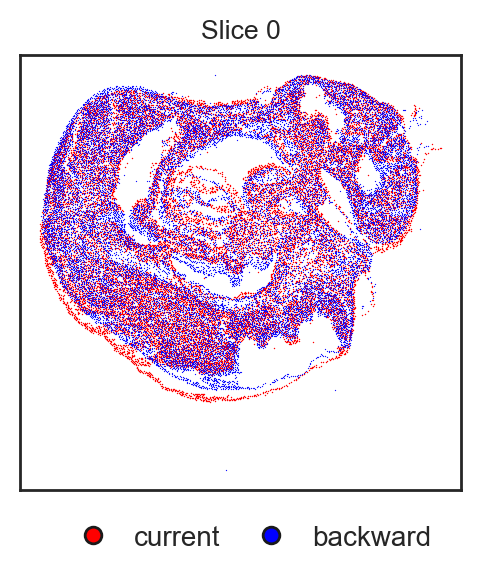

In [13]:
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, height=3, overlay_type='backward',  legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0),'borderaxespad': -2, 'frameon': False})

In general, using GPU computation can significantly improve efficiency, especially as the data scale increases. Therefore, we strongly recommend using GPU computation whenever possible. However, it's important to note that GPU memory is often limited, which can lead to GPU memory overflow with large datasets. To address this, we recommend using the sparse computation and downsampling techniques described below.

## Stochastic variational inference (SVI)

Stochastic variational inference (SVI) works similarly to stochastic gradient descent by using more efficient mini-batches to update variational parameters, thereby speeding up the optimization process. By default, SVI is enabled in Spateo. Another important aspect to consider is the batch size. A batch size that is too large can increase computation time, while one that is too small may lead to imprecise results. Spateo, by default, selects a batch size of `min(max(int(NB / 10), 1000), NB)`, where `NB` represents the the number of spots/cells in slice1. In this section, we set the device to 'cuda' by default. 

### Mouse embryo E9.5 data

We’ll start by testing on the mouse embryo E9.5 dataset (approximately 18,000 spots) to observe how SVI accelerates the alignment process.

In [14]:
slice1 = st.read('./data/E95_cellbin_14.h5ad')
slice2 = st.read('./data/E95_cellbin_15.h5ad')

slice1, slice2

(AnnData object with n_obs × n_vars = 18520 × 20517
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'cellbin_SpatialDomain', 'n_genes'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: '__type', 'hvg', 'log1p', 'louvain', 'neighbors', 'pca', 'pearson_residuals_normalization', 'spatial'
     obsm: 'X_pca', 'X_spatial', 'spatial'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 18322 × 20195
     obs: 'area', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'louvain', 'cellbin_SpatialDomain', 'n_genes'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: '__type', 'hvg', 'log1p', 'louvain', 'neighbors', 'pca', 'pearson_residuals_normalization', 'spatial'
     obsm: 'X_pca', 'X_spatial', 'spatial'
     layers: 'counts')

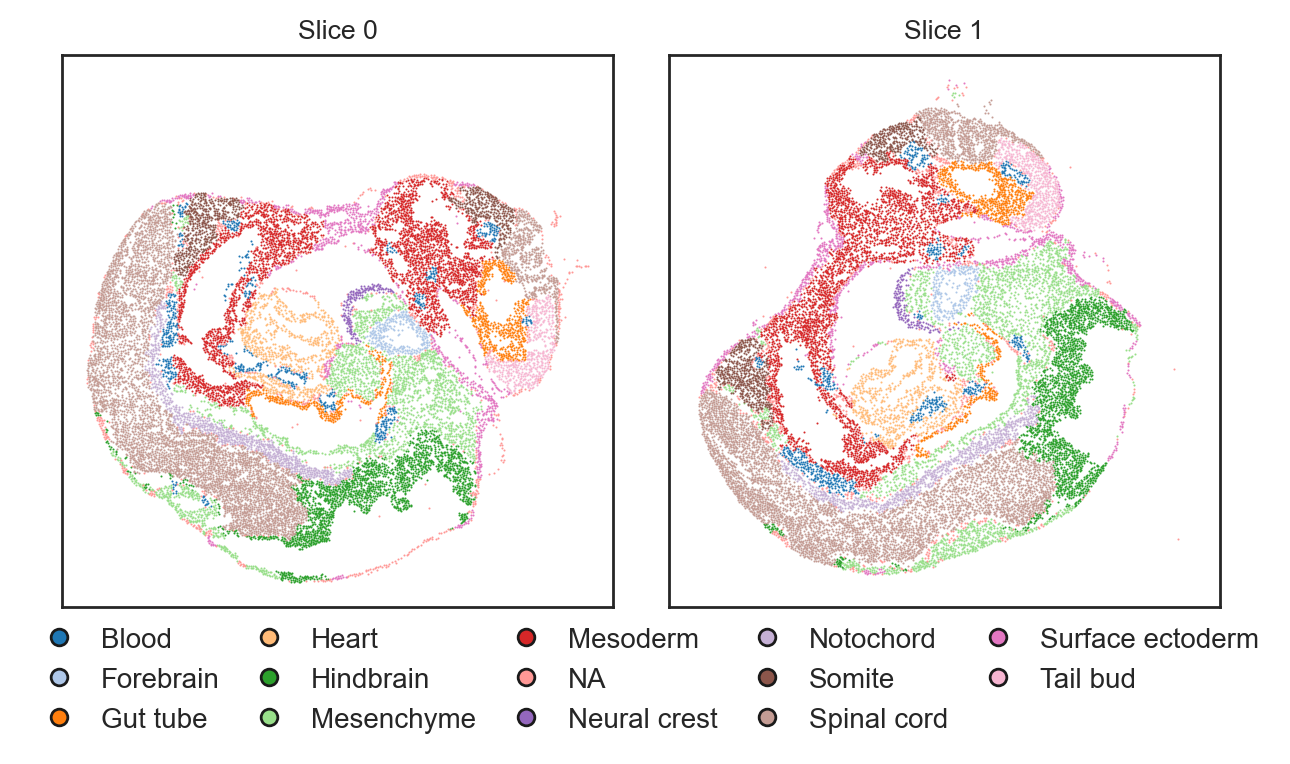

In [15]:
spatial_key = 'spatial'
cluster_key = 'cellbin_SpatialDomain'
st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=True,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
)

In [16]:
key_added = 'align_spatial'

# run on cuda
t_start = time.time()
aligned_slices_SVI, _ = st.align.morpho_align(models=[slice1, slice2],spatial_key=spatial_key,key_added=key_added,device=device,verbose=False, SVI_mode=True)
t_svi_on = time.time() - t_start

# run on cpu
t_start = time.time()
aligned_slices_SVI_off, _ = st.align.morpho_align(models=[slice1, slice2],spatial_key=spatial_key,key_added=key_added,device=device,verbose=False, SVI_mode=False)
t_svi_off= time.time() - t_start

print(f"Alignment on SVI is faster {t_svi_off / t_svi_on} times than no SVI on Mouse embryo E9.5 dataset.")

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [4.2265s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [15.6125s]
Alignment on SVI is faster 3.570188859608413 times than CPU on Mouse embryo E9.5 dataset.


In [21]:
overlay_slices[0].obs['batch']

755      0
762      0
763      0
768      0
775      0
        ..
36102    1
36120    1
36131    1
36132    1
36143    1
Name: batch, Length: 36842, dtype: category
Categories (2, object): ['0', '1']

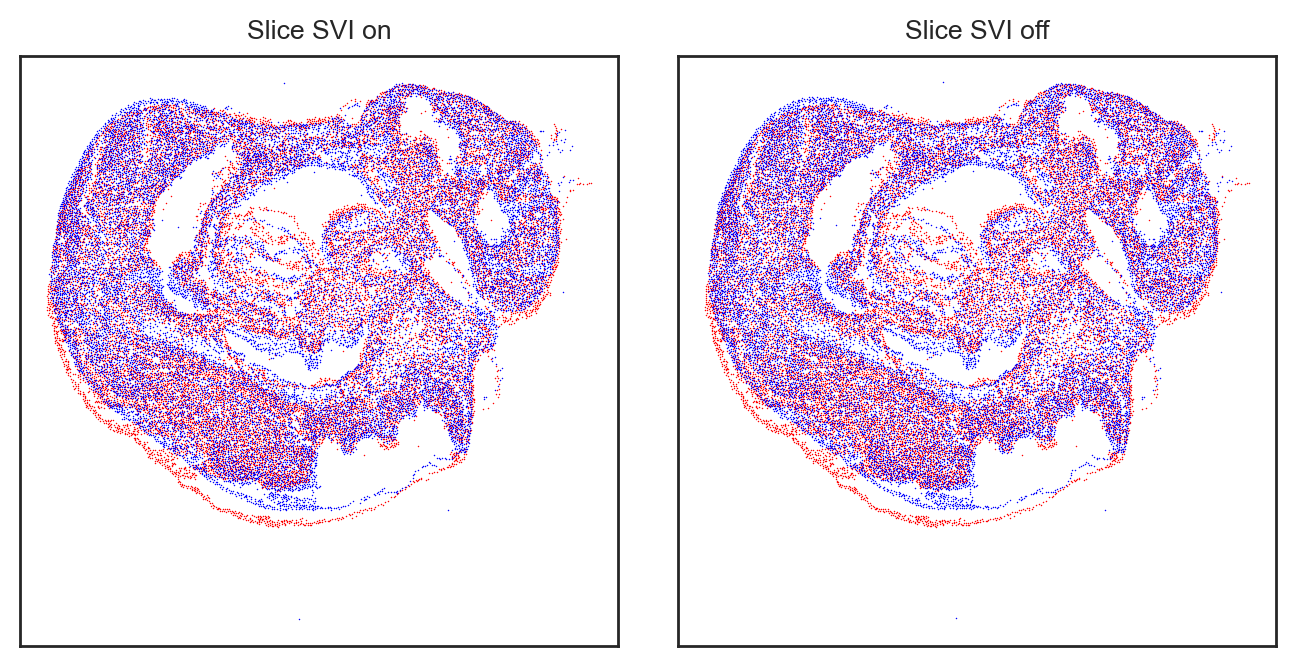

In [23]:
overlay_slices = [ad.concat(aligned_slices_SVI, label='batch'), ad.concat(aligned_slices_SVI_off, label='batch')]
overlay_slices[0].obs['SVI'] = 'SVI on'
overlay_slices[1].obs['SVI'] = 'SVI off'
st.pl.slices_2d(
    slices = overlay_slices,
    label_key = 'batch',
    spatial_key = key_added,
    height=4,
    center_coordinate=False,
    show_legend=False,
    palette={"0": "red","1": "blue"},
    slices_key='SVI',
)

We observe that the results with and without SVI are nearly identical, but the speed is significantly increased when using SVI. However, it's important to note that SVI could sometimes affect the results, as shown in the example below.

### STARMap Plus partial case

In this example, we use STARMap Plus Sagittal #3 pseudo-cut slices with only a 20% overlap ratio (see [Partial alignment](./3.%20Partial%20alignment%20of%20Spateo%20for%202D%20slices.ipynb) for details on generating partially overlapping pseudo-cut slices), making it a very challenging case. Here, Spateo alignment without SVI successfully aligns the slices, whereas using SVI leads to a failed alignment.

In [2]:
slice1 = st.read('./data/sagittal3_partial_1.h5ad')
slice2 = st.read('./data/sagittal3_partial_2.h5ad')

slice1, slice2

(AnnData object with n_obs × n_vars = 30680 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'n_genes', 'slice'
     var: 'n_cells'
     uns: 'Main_molecular_tissue_region_palette', 'log1p', 'pca'
     obsm: 'X_pca', 'spatial', 'spatial_raw'
     varm: 'PCs'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 29610 × 1022
     obs: 'Sub_molecular_cell_type', 'Main_molecular_tissue_region', 'Sub_molecular_tissue_region', 'Molecular_spatial_cell_type', 'n_genes', 'slice'
     var: 'n_cells'
     uns: 'Main_molecular_tissue_region_palette', 'log1p', 'pca'
     obsm: 'X_pca', 'spatial', 'spatial_raw'
     varm: 'PCs'
     layers: 'counts')

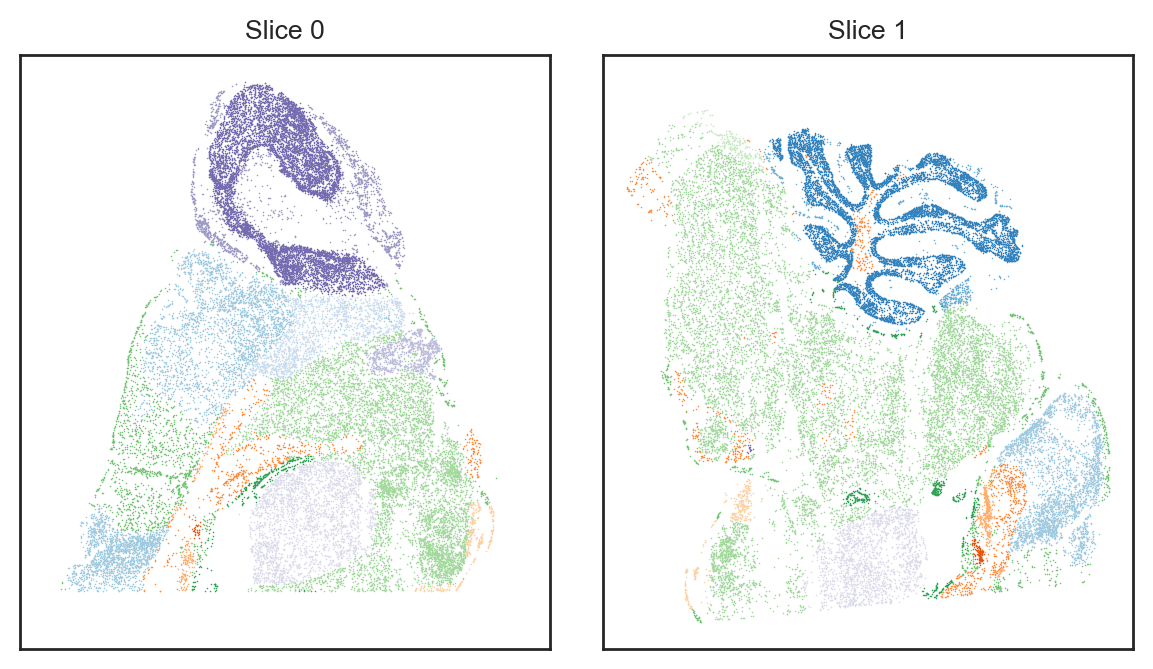

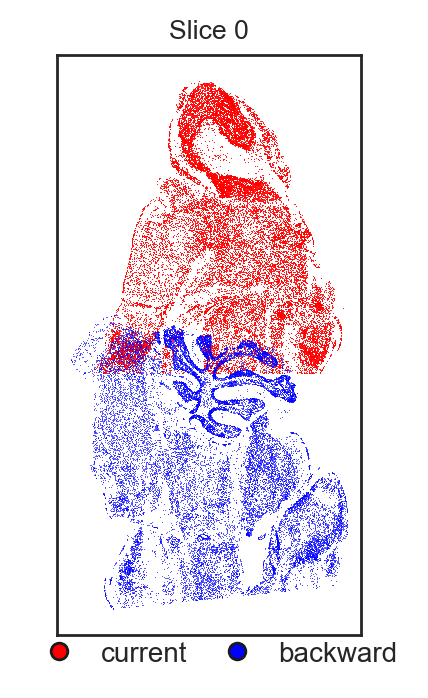

In [3]:
spatial_key = 'spatial'
cluster_key = 'Main_molecular_tissue_region'

st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=True,
    show_legend=False,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    cmap='tab20c',
)
st.pl.overlay_slices_2d(slices = [slice1, slice2], spatial_key = 'spatial', height=4, overlay_type='backward')

In [14]:
key_added = 'align_spatial'

aligned_slices_SVI, _ = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    partial_robust_level=50,
    rep_layer='X_pca',
    rep_field='obsm',
    dissimilarity='cos',
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([14652.2188, 14652.2188])...
|-----------> Scale: tensor([[19077.8555, 22213.2871],
        [20965.7383, 54211.2344]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [4.6815s]
|-----> Key Parameters: gamma: 0.5530375242233276; sigma2: 0.005284715909510851; probability_parameters: [tensor(0.0105, device='cuda:0')]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [0.2908s]


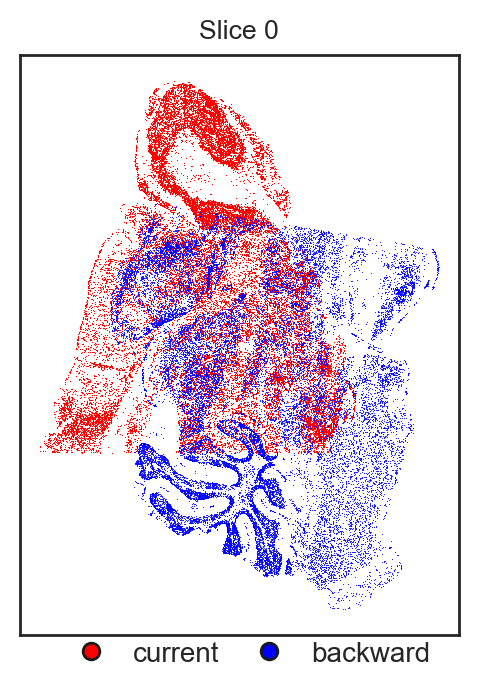

In [15]:
# Visualize the alignment results
st.pl.overlay_slices_2d(slices = aligned_slices_SVI, spatial_key = key_added, height=4, overlay_type='backward')

In [12]:
key_added = 'align_spatial'

aligned_slices_no_SVI, _ = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    partial_robust_level=50,
    rep_layer='X_pca',
    rep_field='obsm',
    dissimilarity='cos',
    SVI_mode=False,
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 1022 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([14652.2188, 14652.2188])...
|-----------> Scale: tensor([[19077.8555, 22213.2871],
        [20965.7383, 54211.2344]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [32.4946s]
|-----> Key Parameters: gamma: 0.22027459740638733; sigma2: 0.0010000000474974513; probability_parameters: [tensor(0.0105, device='cuda:0')]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [2.8376s]


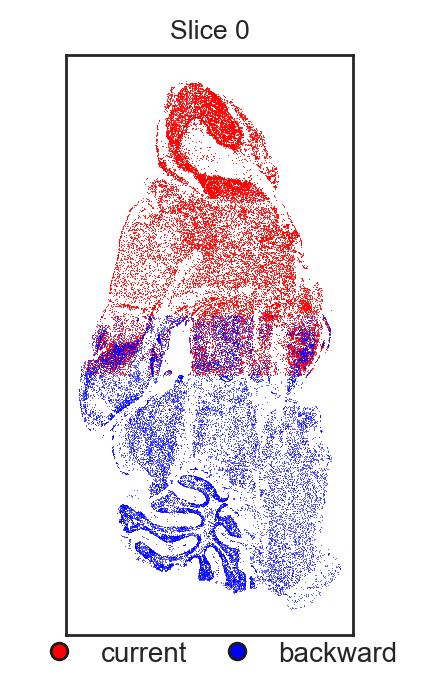

In [13]:
# Visualize the alignment results
st.pl.overlay_slices_2d(slices = aligned_slices_no_SVI, spatial_key = key_added, height=4, overlay_type='backward')

## Inducing variables approximation

Inducing variables are used to overcome the high computational complexity of Gaussian processes (related to the nonrigid transformation), significantly reducing computational costs. However, it's important to note that setting too few inducing variables can limit the flexibility of nonrigid transformations.

### Drosophila data

We demonstrate the effect of inducing variables using the Drosophila dataset.

In [44]:
slice1 = st.read('./data/Drosophila_E7-9h_slice_16.h5ad')
slice2 = st.read('./data/Drosophila_E7-9h_slice_17.h5ad')

slice1, slice2

(AnnData object with n_obs × n_vars = 1229 × 8136
     obs: 'area', 'slices', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 'scc', 'auto_anno', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'Size_Factor', 'initial_cell_size'
     obsm: 'spatial'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 996 × 8136
     obs: 'area', 'slices', 'nGenes', 'nCounts', 'pMito', 'nMito', 'pass_basic_filter', 'scc', 'auto_anno', 'anno_cell_type', 'anno_tissue', 'anno_germ_layer', 'actual_stage', 'Size_Factor', 'initial_cell_size'
     obsm: 'spatial'
     layers: 'counts')

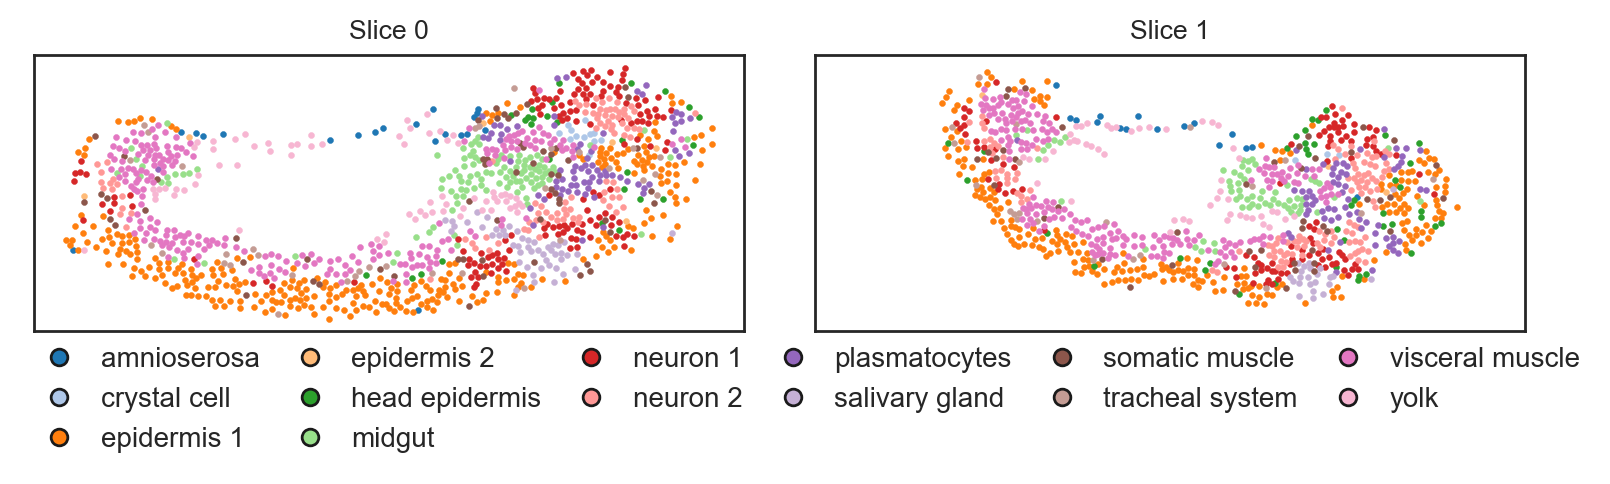

In [46]:
spatial_key = 'spatial'
cluster_key = 'anno_cell_type'

st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=2,
    center_coordinate=True,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0) ,'ncol': 6, 'borderaxespad': -2, 'frameon': False},
)

In [47]:
import time
K_list = [2, 3, 5, 10, 15, 20, 30, 50, 100, 200, 500, 1000]
t_list = []
# iterate all the parameters
st.align.group_pca([slice1, slice2], pca_key='X_pca')
aligned_slices = [slice1, slice2]
spatial_key = 'spatial'
for K in K_list:
    key_added = f"align_spatial_{K}"
    t_start = time.time()
    aligned_slices, pis = st.align.morpho_align(
        models=aligned_slices,
        spatial_key=spatial_key,
        key_added=key_added,
        device=device,
        beta=1,
        lambdaVF=1,
        K=K,
        verbose=False,
        rep_layer='X_pca',
        rep_field='obsm',
        dissimilarity='cos',
    )
    t_end = time.time()
    t = t_end - t_start
    t_list.append(t)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [1.2023s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [1.0977s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [1.1213s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [1.1164s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [1.1541s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [1.0897s]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.000

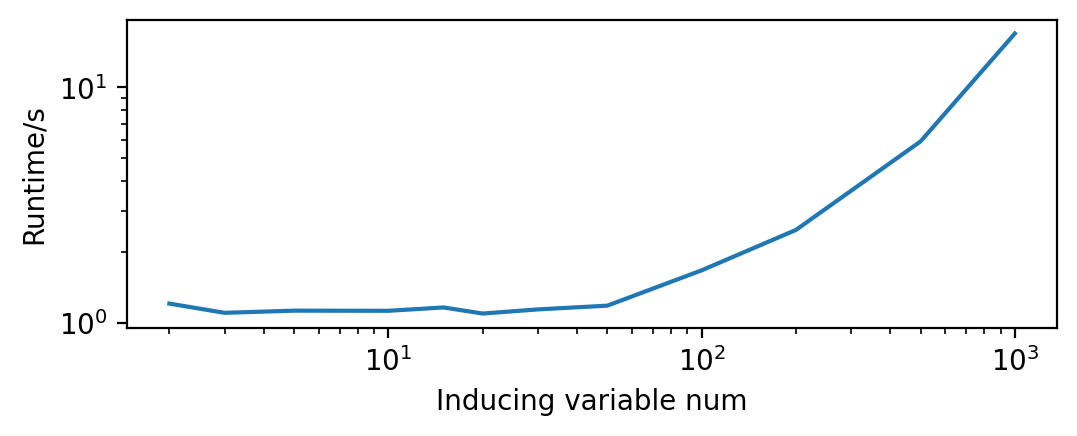

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
ax.plot(K_list, t_list)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Inducing variable num')
ax.set_ylabel('Runtime/s')
plt.show()

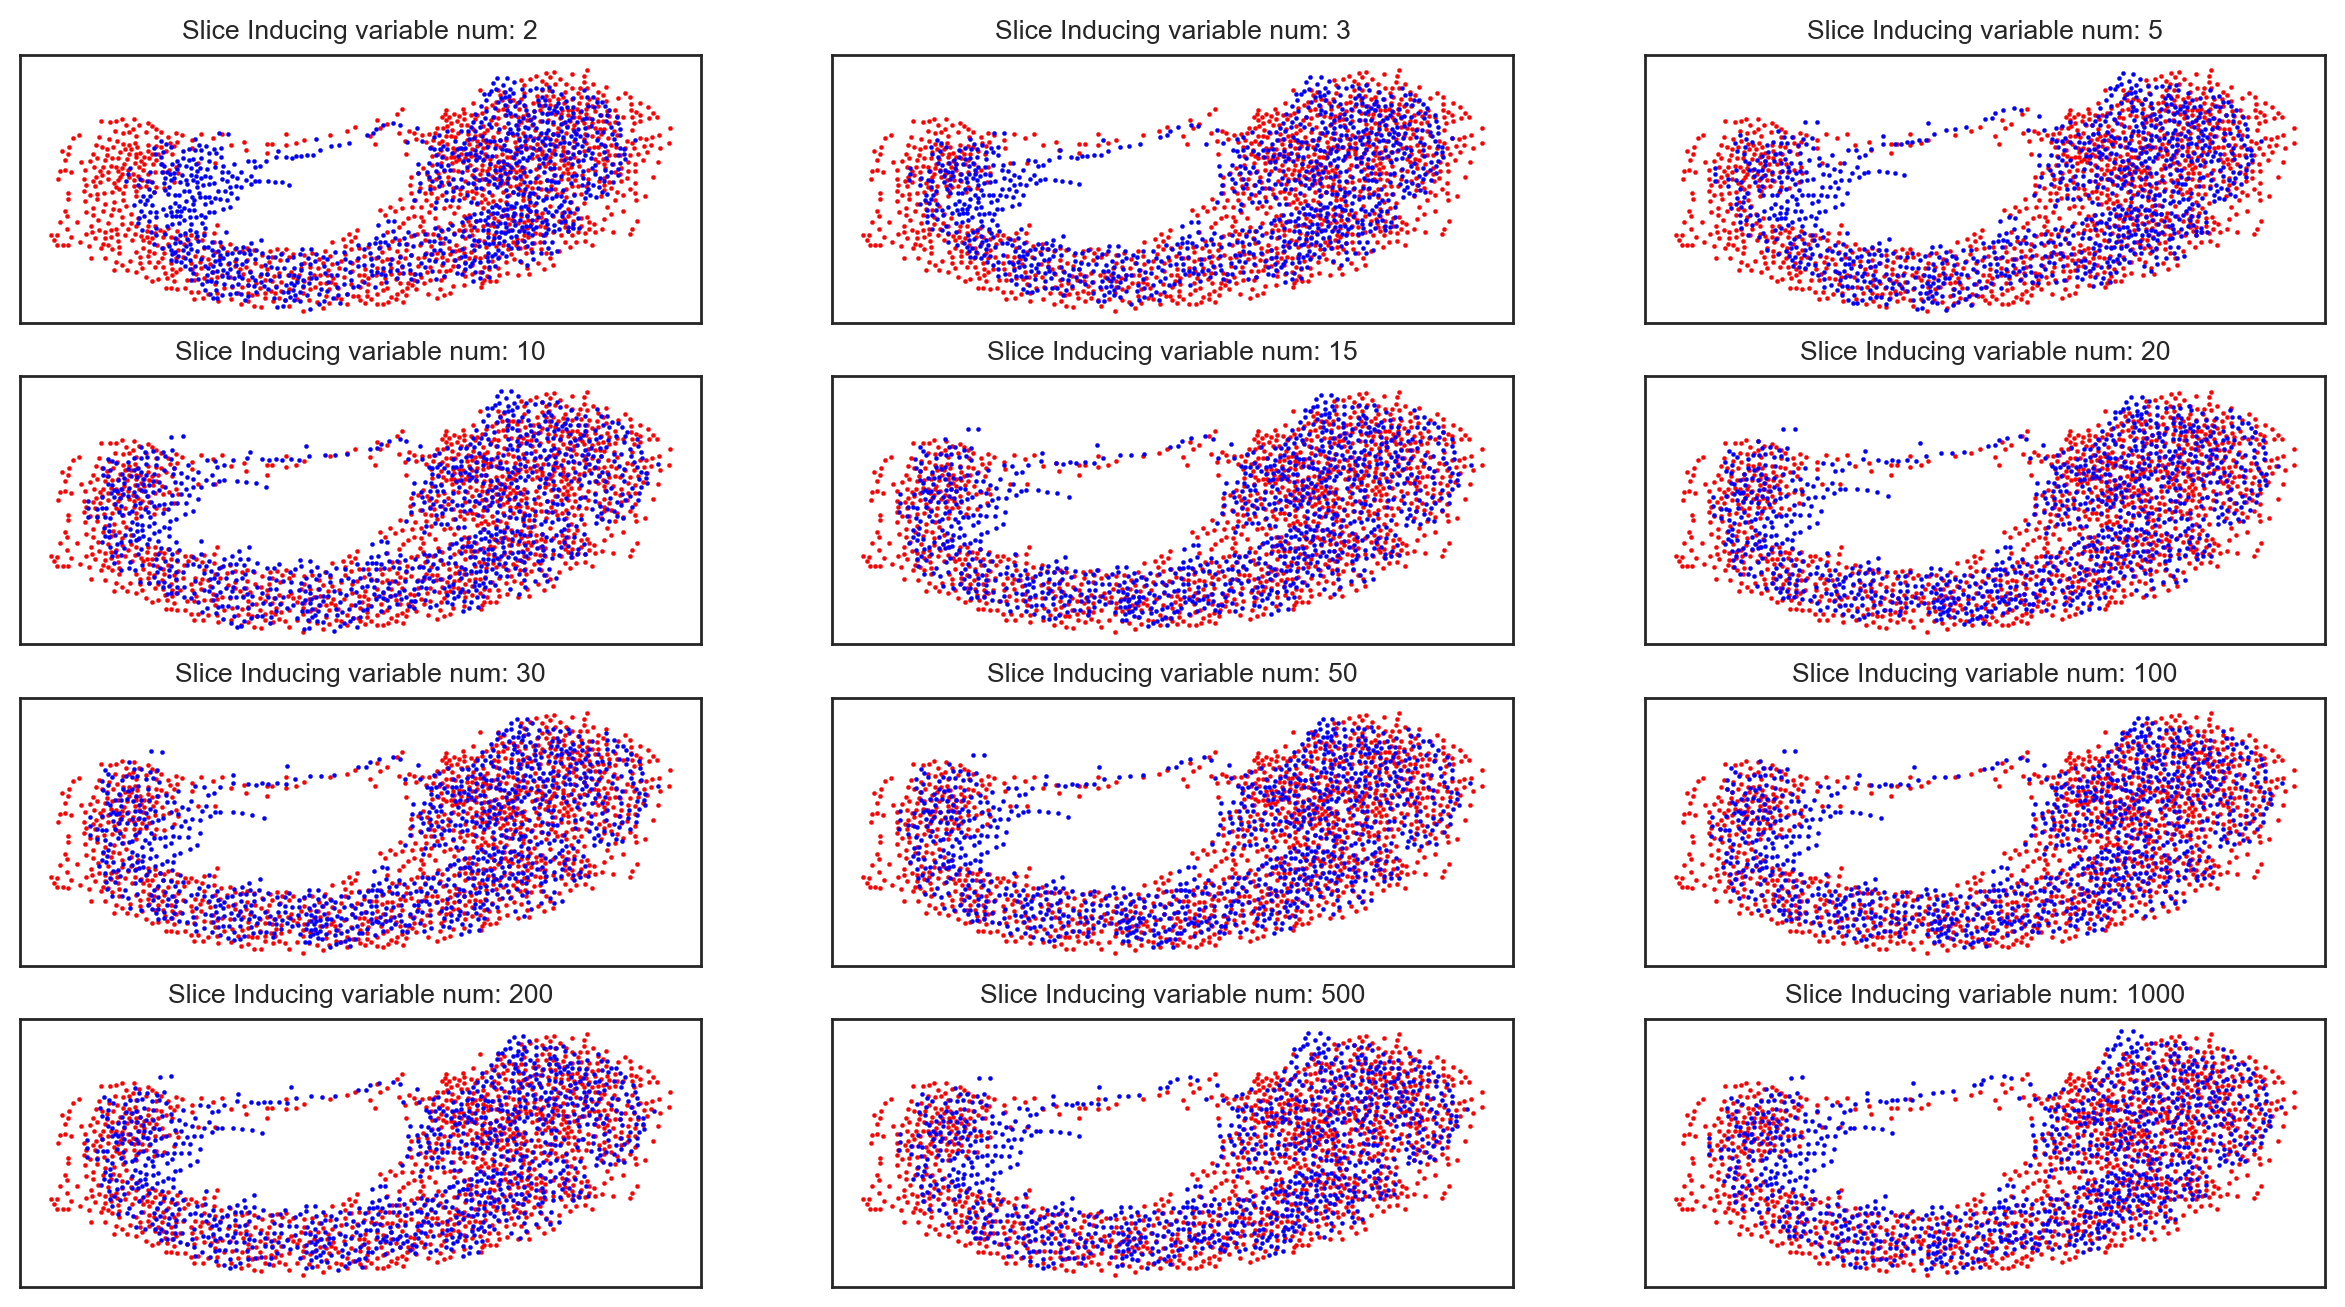

In [49]:
overlay_slices = []
for i, K in enumerate(K_list):
    key_added = f"align_spatial_{K}"
    cur_slice1 = slice1.copy()
    cur_slice2 = slice2.copy()

    cur_slice1.obsm['aligned_spatial'] = cur_slice1.obsm[spatial_key].copy()
    cur_slice2.obsm['aligned_spatial'] = aligned_slices[1].obsm[key_added+'_nonrigid'].copy()
    concat_slice = ad.concat([cur_slice1, cur_slice2], label='batch')
    concat_slice.obs['Inducing variable num'] = f'Inducing variable num: {K}'
    overlay_slices.append(concat_slice)

st.pl.slices_2d(
    slices = overlay_slices,
    label_key = 'batch',
    spatial_key = 'aligned_spatial',
    height=2,
    center_coordinate=False,
    show_legend=False,
    palette={"0": "red","1": "blue"},
    ncols=3,
    slices_key='Inducing variable num',
)

## Downsampling

For large datasets, downsampling is also a good option to significantly reduce computational costs, typically with minimal impact on accuracy. In Spateo, we call ``st.align.morpho_align_ref`` for alignment with downsampling.

### AllenBrain Zhuang data

We first demonstrate downsampling with the AllenBrain (Zhuang) dataset obtained using MERFISH, which contains approximately 50,000 cells.

In [16]:
slice1 = st.read('./data/AllenBrain_Zhuang_slice_78.h5ad')
slice2 = st.read('./data/AllenBrain_Zhuang_slice_79.h5ad')

slice1, slice2

(AnnData object with n_obs × n_vars = 51112 × 1122
     obs: 'major_brain_region', 'ccf_region_name', 'brain_section_label', 'tissue_type', 'cell_type', 'is_primary_data'
     uns: 'pca'
     obsm: 'X_CCF', 'X_pca', 'X_spatial_coords', 'X_umap', 'spatial'
     varm: 'PCs',
 AnnData object with n_obs × n_vars = 50126 × 1122
     obs: 'major_brain_region', 'ccf_region_name', 'brain_section_label', 'tissue_type', 'cell_type', 'is_primary_data'
     uns: 'pca'
     obsm: 'X_CCF', 'X_pca', 'X_spatial_coords', 'X_umap', 'spatial'
     varm: 'PCs')

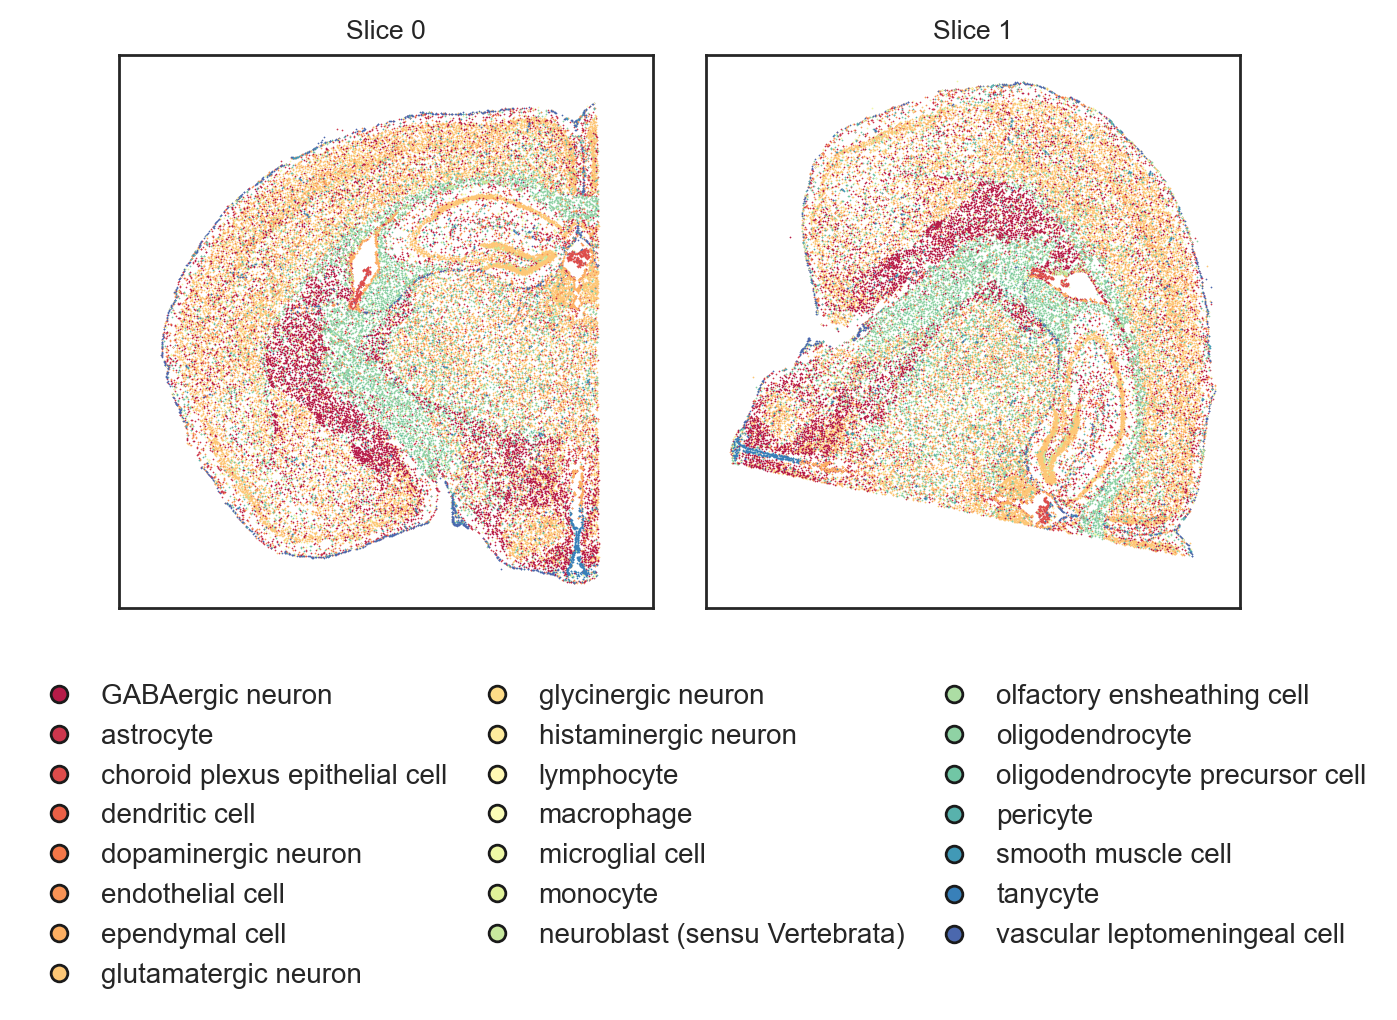

In [23]:
spatial_key = 'X_spatial_coords'
cluster_key = 'cell_type'

st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=True,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.5, 0) ,'ncol': 3, 'borderaxespad': -2, 'frameon': False},
    cmap='Spectral',
    point_size=0.3,
)

Let us first try full alignment without downsampling

In [24]:
spatial_key = 'X_spatial_coords'
key_added = 'align_spatial'
aligned_slices_full, _ = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    verbose=False,
    beta=1,
    lambdaVF=1,
    K=50,
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [16.9170s]


We observe that Spateo's alignment produces excellent results, with nonrigid alignment further enhancing the finer details.

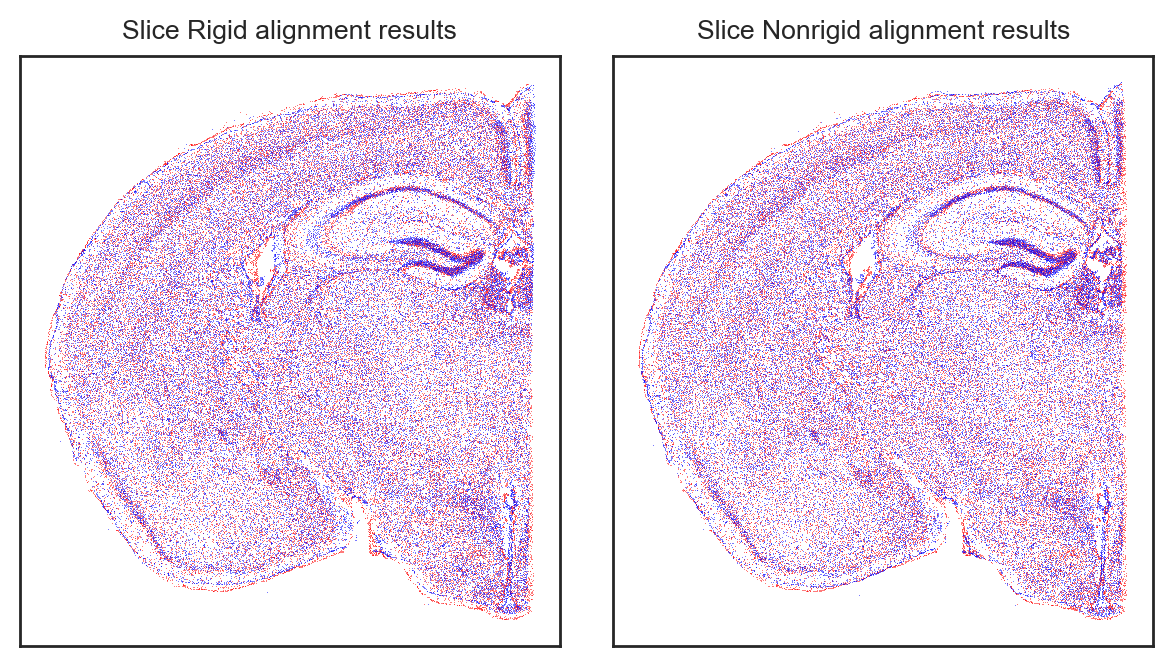

In [26]:
overlay_slices = [ad.concat(aligned_slices_full, label='batch'), ad.concat(aligned_slices_full, label='batch')]
overlay_slices[0].obs['label'] = 'with rigid alignment'
overlay_slices[1].obs['label'] = 'with nonrigid alignment'
overlay_slices[1].obsm[key_added] = overlay_slices[1].obsm[key_added+'_nonrigid'].copy()
st.pl.slices_2d(
    slices = overlay_slices,
    label_key = 'batch',
    spatial_key = key_added,
    height=4,
    center_coordinate=False,
    show_legend=False,
    palette={"0": "red","1": "blue"},
    slices_key='label',
)

Next, we use a downsampling of 10,000 cells, which significantly reduces processing time and memory consumption. Using downsampling is straightforward; you only need to specify ``n_sampling``, and the function ``st.align.morpho_align_ref`` will perform random sampling internally. If you prefer the samples to be uniformly distributed across the dataset, you can set ``sampling_method="trn"`` or ``"kmeans"``, although this will significantly slow down the process. The first two outputs of the function are the aligned original sample and the aligned downsampled sample, where the spatial transformation applied to the original sample is based on the downsampled sample's results.

In [27]:
aligned_slices_down, aligned_slices_ref, _, _ = st.align.morpho_align_ref(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    n_sampling=10000,
    key_added=key_added,
    device=device,
    verbose=False,
    beta=1,
    lambdaVF=1,
    K=50,
)

|-----> [Models alignment with ref-models based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment with ref-models based on morpho, mode: SN-S.] finished [2.5631s]


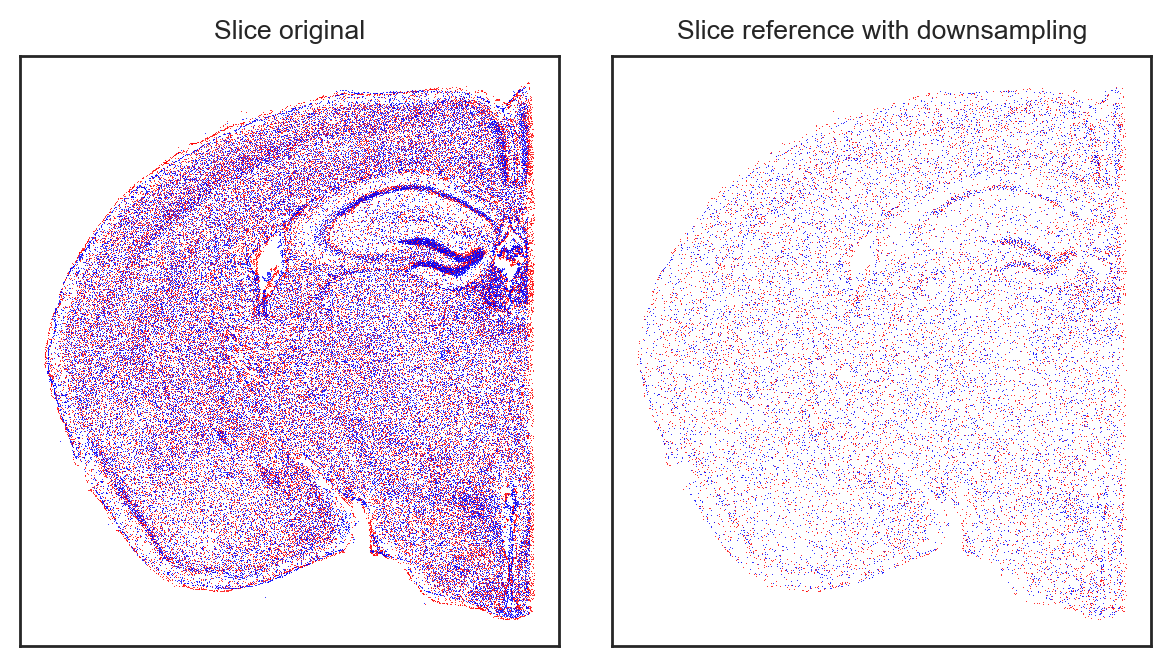

In [28]:
overlay_slices = [ad.concat(aligned_slices_down, label='batch'), ad.concat(aligned_slices_ref, label='batch')]
overlay_slices[0].obs['label'] = 'original'
overlay_slices[1].obs['label'] = 'reference with downsampling'
st.pl.slices_2d(
    slices = overlay_slices,
    label_key = 'batch',
    spatial_key = key_added+'_nonrigid',
    height=4,
    center_coordinate=False,
    show_legend=False,
    palette={"0": "red","1": "blue"},
    slices_key='label',
)

Let's compare this with the results obtained using the full data. We can see that using the full dataset yields better results, but the downsampled results are still acceptable.

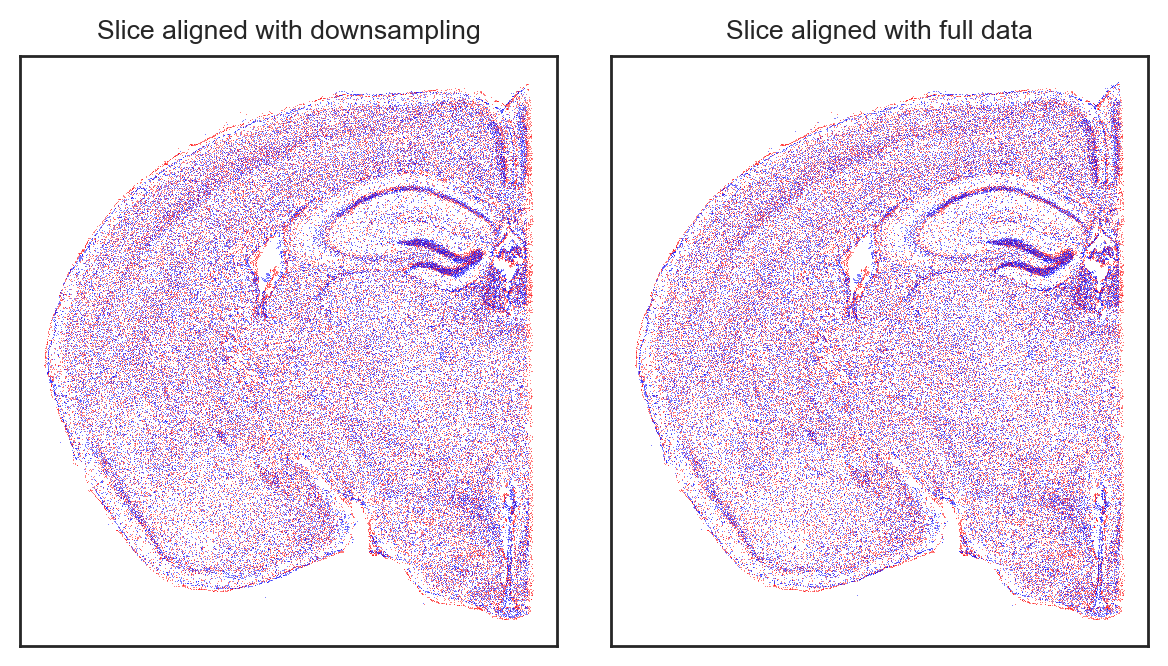

In [32]:
overlay_slices = [ad.concat(aligned_slices_down, label='batch'), ad.concat(aligned_slices_full, label='batch')]
overlay_slices[0].obs['label'] = 'aligned with downsampling'
overlay_slices[1].obs['label'] = 'aligned with full data'
st.pl.slices_2d(
    slices = overlay_slices,
    label_key = 'batch',
    spatial_key = key_added+'_nonrigid',
    height=4,
    center_coordinate=False,
    show_legend=False,
    palette={"0": "red","1": "blue"},
    slices_key='label',
)

## Sparse computation

Although Spateo is already highly efficient, handling even larger datasets—such as samples with over 100k cells—can easily lead to memory overflow due to limited GPU memory. In fact, on GPUs, computing a similarity matrix alone can consume substantial memory at this scale. To enable Spateo to scale to even larger datasets, we developed sparse computation based on ``torch.sparse_coo_tensor`` and ``scipy.sparse.coo_matrix``. The key insight here is that the most memory-intensive step in the Spateo algorithm is computing the posterior generation probability, i.e.,  updating $q_2$. Notably, this matrix is often highly sparse; for example, if two points are very distant, their generation probability is minimal. By ignoring these low values, we can leverage sparse computation without significantly impacting accuracy, making large-scale processing feasible. In addition, chunk computation can also reduce memory consumption. However, it’s important to note that both sparse and chunk computation techniques will reduce computational efficiency.

### Allen Mouse Cell Atlas datasets

We demonstrate this using Allen Mouse Cell Atlas datasets, which contains about 100,000 cells per slice.

In [33]:
slice1 = ad.read_h5ad('./data/AllenMouseCellAtlas_slice_30.h5ad')
slice2 = ad.read_h5ad('./data/AllenMouseCellAtlas_slice_31.h5ad')

slice1, slice2

(AnnData object with n_obs × n_vars = 90145 × 550
     obs: 'brain_section_label', 'cluster_alias', 'class', 'cluster', 'neurotransmitter', 'subclass', 'supertype'
     var: 'gene_symbol', 'transcript_identifier'
     uns: 'class_palette', 'cluster_palette', 'neurotransmitter_palette', 'subclass_palette', 'supertype_palette'
     obsm: 'X_pca', 'spatial',
 AnnData object with n_obs × n_vars = 120186 × 550
     obs: 'brain_section_label', 'cluster_alias', 'class', 'cluster', 'neurotransmitter', 'subclass', 'supertype'
     var: 'gene_symbol', 'transcript_identifier'
     uns: 'class_palette', 'cluster_palette', 'neurotransmitter_palette', 'subclass_palette', 'supertype_palette'
     obsm: 'X_pca', 'spatial')

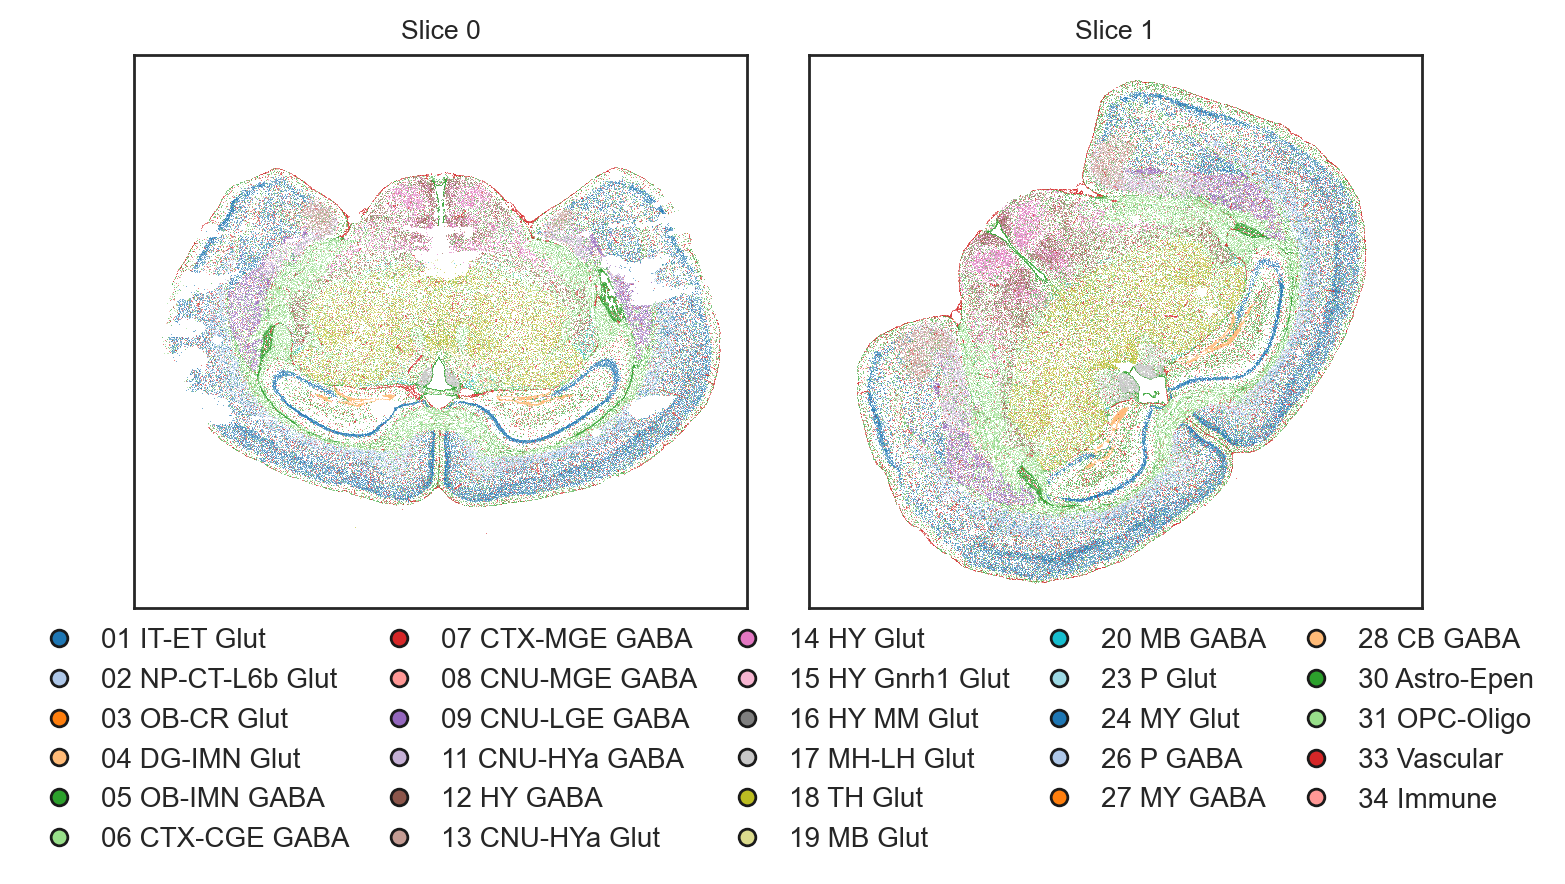

In [34]:
spatial_key = 'spatial'
cluster_key = 'class'

st.pl.slices_2d(
    slices = [slice1, slice2],
    label_key = cluster_key,
    spatial_key = spatial_key,
    height=4,
    center_coordinate=True,
    show_legend=True,
    legend_kwargs={'loc': 'upper center', 'bbox_to_anchor': (0.49, 0) ,'ncol': 5, 'borderaxespad': -4, 'frameon': False},
    cmap='tab20',
)

Using sparse computation is straightforward; simply set ``sparse_calculation_mode=True``. For chunk computation, set ``use_chunk=True`` and specify ``chunk_capacity``. A larger chunk_capacity indicates a larger chunk size, which increases speed but also memory consumption, and vice versa. Here, we set it to 4.

In [35]:
spatial_key = 'spatial'
key_added = 'aligned_spatial'

aligned_slices, pis = st.align.morpho_align(
    models=[slice1, slice2],
    spatial_key=spatial_key,
    key_added=key_added,
    device=device,
    # nonrigid related
    beta=1,
    lambdaVF=1,
    K=30,
    # sparse and chunk calculation
    sparse_calculation_mode=True,
    use_chunk=True,
    chunk_capacity=4,
    verbose=True,
    # use PCA feature
    rep_layer='X_pca',
    rep_field='obsm',
    dissimilarity='cos',
)

|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%|-----> Filtered all samples for common genes. There are 550 common genes.
|-----> Spatial coordinates normalization params:
|-----------> Scale: tensor([3.0572, 3.0572])...
|-----------> Scale: tensor([[5.5743, 5.2255],
        [5.6632, 5.2051]], device='cuda:0')...
|-----> Preprocess finished.
|-----> Performing coarse rigid alignment...
|-----> Coarse rigid alignment done.
|-----> [Start Spateo pairwise alignment] in progress: 100.0000%
|-----> [Start Spateo pairwise alignment] finished [104.0663s]
|-----> Key Parameters: gamma: 0.9900000095367432; sigma2: 0.0012893097009509802; probability_parameters: [tensor(0.0100, device='cuda:0')]
|-----> [Models alignment based on morpho, mode: SN-S.] in progress: 100.0000%
|-----> [Models alignment based on morpho, mode: SN-S.] finished [0.2791s]


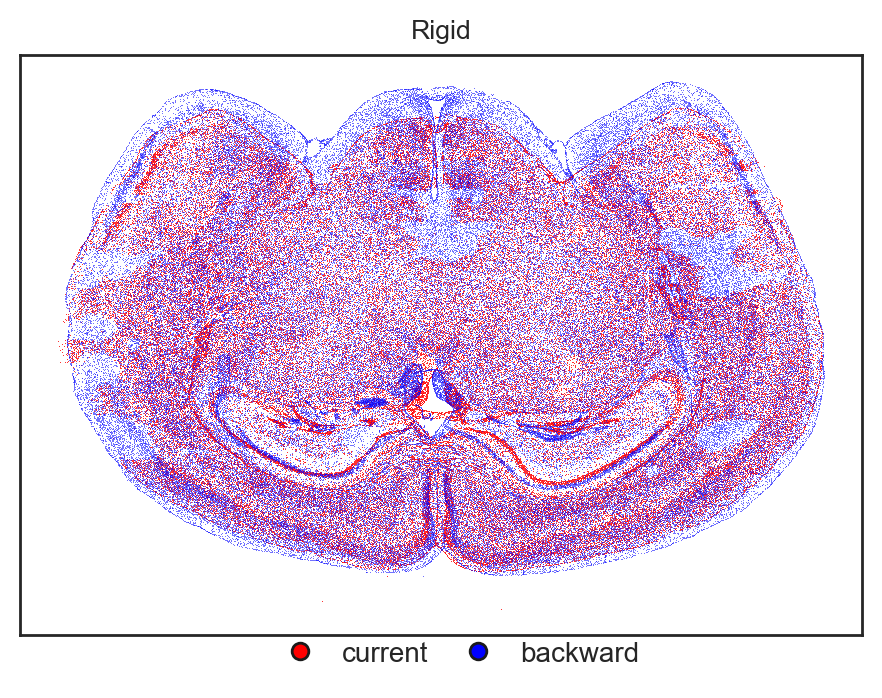

In [39]:
# Visualize the alignment results
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added, height=4, overlay_type='backward', title='Rigid alignment', slices_key=False)

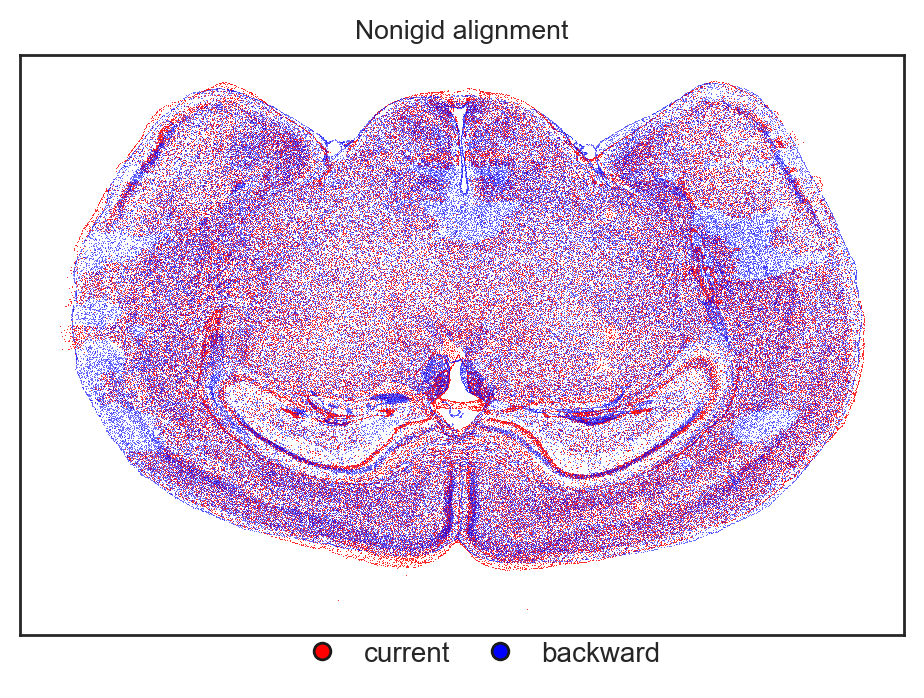

In [40]:
# Visualize the alignment results
st.pl.overlay_slices_2d(slices = aligned_slices, spatial_key = key_added+'_nonrigid', height=4, overlay_type='backward', title='Nonigid alignment', slices_key=False)